In [22]:
# -- Import libraries --
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import re, string, unicodedata
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import plotly.express as px
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
# -- Load data --
train = pd.read_csv("/content/drive/MyDrive/SYDE522Project/data/Corona_NLP_train.csv", encoding='L1',
                    parse_dates=['TweetAt'], index_col='TweetAt')
test = pd.read_csv("/content/drive/MyDrive/SYDE522Project/data/Corona_NLP_test.csv", encoding='L1',
                   parse_dates=['TweetAt'], index_col='TweetAt')

Sentiment distribution

In [24]:
# -- Data distribution -- 
fig = px.bar(train['Sentiment'].value_counts(), 
             x=['Positive','Negative','Neutral','Extremely Positive','Extremely Negative'], 
             y='Sentiment',color=['Positive','Negative','Neutral','Extremely Positive','Extremely Negative'])

fig.show()

In [25]:
# -- Remove any rows with NAs in the OriginalTweet and Sentiment columns  --
train.OriginalTweet.dropna()
train.Sentiment.dropna()
test.OriginalTweet.dropna()
test.Sentiment.dropna()

TweetAt
2020-02-03    Extremely Negative
2020-02-03              Positive
2020-02-03    Extremely Positive
2020-02-03              Negative
2020-03-03               Neutral
                     ...        
2020-03-16              Positive
2020-03-16              Negative
2020-03-16               Neutral
2020-03-16    Extremely Negative
2020-03-16    Extremely Positive
Name: Sentiment, Length: 3798, dtype: object

In [26]:
def clean_data(tweet):

  # -- remove URLS --
  tweet = re.sub(r"http\S+", "", tweet)

  # -- lower case --
  tweet = tweet.lower()

  # -- remove digits --
  tweet = re.sub(r'\d+',' ', tweet)

  # -- remove hashtags --
  tweet = re.sub(r'#\w+',' ', tweet)

  # -- remove mentions -- 
  tweet = re.sub(r'@\w+',' ', tweet)

  # remove non-ASCII characters
  tweet = re.sub(r'[^\x00-\x7f]',r'', tweet) 

  # -- remove stop words --
  tweet = tweet.split()
  tweet = " ".join([word for word in tweet if not word in stopwords.words('english')])

  return tweet

In [27]:
train['OriginalTweet'] = train['OriginalTweet'].apply(clean_data)
test['OriginalTweet'] = test['OriginalTweet'].apply(clean_data)

Temporal distribution

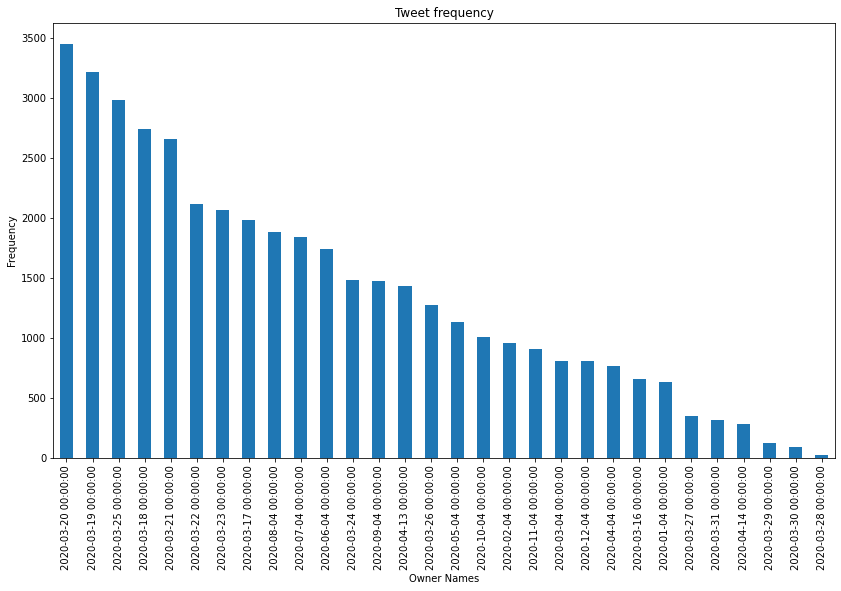

In [21]:
ax = train.index.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Tweet frequency")
ax.set_xlabel("Owner Names")
ax.set_ylabel("Frequency")
plt.show()


In [28]:
# -- Convert labels to categorical --
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"

train['Sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))


Positive - wordcloud

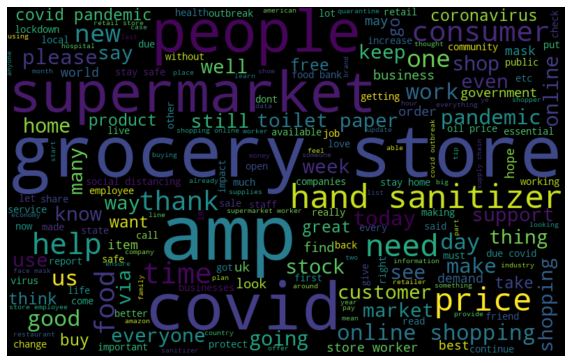

In [29]:
positive = ' '.join([text for text in train[train['Sentiment'] == '2']['OriginalTweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Negative - wordcloud

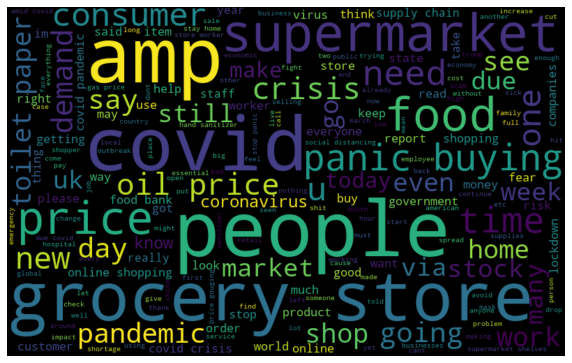

In [30]:
negative = ' '.join([text for text in train[train['Sentiment'] == '0']['OriginalTweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [31]:
fig = px.bar(train['Sentiment'].value_counts(), 
             x=['Positive','Negative','Neutral'], 
             y='Sentiment',color=['Positive','Negative','Neutral'])
fig.show()

Data transformations

In [40]:
# -- Convert texts into more managable representations (TF-IDF weighted vectors) --
tfidf = TfidfVectorizer(sublinear_tf = True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(train['OriginalTweet'])
test_features = tfidf.transform(test['OriginalTweet'])

(3798, 19823)

In [42]:
# -- Split training data into training and validation sets --
X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(features, 
                                                                      train['Sentiment'],
                                                                      test_size= 0.1)

Y_test = test['Sentiment']

Experiment with different supervised multi-class classifiers and evaluate their accuracy

Random Forest

Linear SVM

Multinomial Naive Bayes

In [34]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=300),
    ]
CV = 5
CV_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
CV_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Plot accuracies 

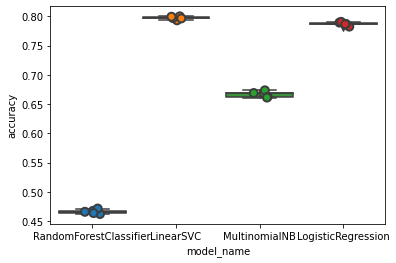

In [35]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=CV_df)
sns.stripplot(x='model_name', y='accuracy', data=CV_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [36]:
CV_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.797036
LogisticRegression        0.787020
MultinomialNB             0.666883
RandomForestClassifier    0.466375
Name: accuracy, dtype: float64

Based on the accuracies, I see that Linear SVC performs the best. I will further evaluate the performace of this model.

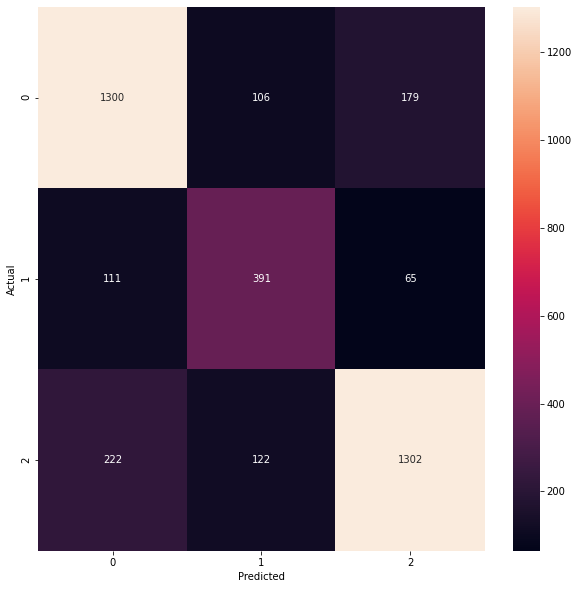

In [47]:
model = LinearSVC()

model.fit(X_train, Y_train)
Y_pred = model.predict(test_features)

c_matrix = confusion_matrix(Y_pred, Y_test)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(c_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [52]:
print(metrics.classification_report(Y_test, Y_pred, 
                                    target_names= Y_test.unique()))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1633
           2       0.69      0.63      0.66       619
           1       0.79      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.76      0.76      3798
weighted avg       0.79      0.79      0.79      3798

